# Projet AI09 - Problèmes de transports

<img style="position:float; float:right" src="logo_utc.png" alt="Logo UTC" width="200"/>

### Par GHALIA Mostafa, DERBALI Karim et BOUCHDI Yassine
### Encadré par M Moukrim

<img style="  display: block; margin: auto;" src="entete.png" alt="Entete" />


# Résumé
Ce document est un rapport effectué sur une variante du problème de tournée de véhicule, communément appelé ``Vehicle Routing Problem (VRP)``. Ce sujet est toujours d’actualité et est toujours en cours d’amélioration pour réduire la ``complexité`` d’exécution ``temporelle`` et/ou ``spatiale``. Beaucoup d’entreprises utilisant la logistique ont leurs propres algorithmes qui fonctionnent mieux que la majorité et qui peuvent être en raison de leur succès d’aujourd’hui comme Amazon.	
La variante que nous étudions se nomme le problème de ``tournée de véhicule sélectif`` ou encore appelé ``Team Orienteering Problem (TOP)``, où à priori il n’est pas possible de servir tous les clients.	
À travers ce mémoire, nous allons étudier le problème selon une ``instance`` que nous proposerons et expliquerons l’approche que nous allons avoir pour résoudre le problème. Une heuristique ou une méthode exacte sera présentée tout le long du mémoire.

# Contexte

Plusieurs types de contraintes peuvent être associés au problème de tournée sélective tels qu’une ``fenêtre de temps``, la ``distance``, le`` nombre de véhicules`` et d’autres.
L’analyse ``TOP`` est un problème de tournées de véhicules très spécifique puisque les missions d’analyse ont une très longue durée alors même que plusieurs centaines voire milliers de points sont visités chaque jour. Le problème peut donc se modéliser comme un ``Team Orienteering Problem``, avec des points obligatoires et des points optionnels à visiter. Quand tous les points obligatoires d’une zone ont été visités, les capteurs sont déplacés et les ensembles de points obligatoires et optionnels évoluent. L’objectif du problème est donc la ``maximisation`` du nombre de points visités tout en respectant les contraintes opérationnelles du problème. Nous retrouvons entre autres la classique limite temporelle sur la durée des tournées, une contrainte sur la ``distance maximum`` entre les différents véhicules, la présence de points obligatoires ou encore l’absence de dépôt final.

Dans notre cas, il nous a été donné les consignes suivantes : 
- Un groupe de point et leurs coordonnées sont à proposer (instance)
- Chaque point lui est associé un profit
- Un nombre de véhicules m est imposé, un véhicule correspond à une tournée
- Un véhicule doit maximiser le profit en passant par les points de l’instance
- Un point ne peut être visité qu’une fois toutes tournées confondues
- Une tournée ne peut dépasser une distance maximum Lmax
- Un véhicule doit démarrer d’un point de dépôt et terminer à un point d’arrivée


# Méthodes & Résultats

Précision : Tout le long de l'explication de notre démarche, les parties de codes correspondantes suivront avec les résultats affichés dans le cas échéant.

## Outil de résolution
Nous avons pris le choix de nous diriger vers une résolution du problème en méthode ``solveur``. Une heuristique est tout à fait capable de résoudre le problème, mais nous avons une préférence avec les méthodes de ``'force brute'``.
Résoudre un problème tel que le TOP à l'aide d'un soldeur nous impose une approche spécifique qui est la ``programmation linéaire``. Nous devons effectuer la modélisation du problème sous forme de PL en nombres entiers. 

La PL est une ``méthode d’optimisation`` permettant de déterminer la solution optimale à un problème mathématique formulé avec des équations dites linéaires.

Nous avions le choix de plusieurs soldeur à notre disposition telle que GNU Prolog, ASP et d'autres. Mais nous avons décidé de sélectionner ``l'outil PuLP``: 

PuLP est une bibliothèque open source pour la ``programmation linéaire`` en Python. Elle met à disposition tous les outils pour modéliser un problème et les résoudre en faisant appel à différents types de solveurs standards utilisant des algorithmes de résolution différents. C'est en fait un wrapper qui permet la formulation du problème en Python.

In [5]:
# Import des librairies
import itertools
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp
import warnings
warnings.filterwarnings("ignore")


## Modélisation du problème

### Paramètres et Instance

Nous avons sélectionné un groupe de 19 points avec des coordonnées reparti entre -8 et 8 sur x et y. Ils sont représentés sous forme de tableau. À chaque point, un profit est associé. Les points de dépôt et d'arrivée sont situés respectivement au début et à la fin du tableau. Nous avons défini les profits de ces points à 0.

Nous avons fixé le nombre de véhicules maximal à 3 et fixé la distance maximum euclidienne que le véhicule doit parcourir à 18.

In [6]:
# Définition des sommets et des profits associés
data = pd.DataFrame({
    'x': [-2, 3, -1, 1, -6, -4, -4, 1, -6, 3, -4, -3, -1, 7, 5, 6, 2, -5, 2],
    'y': [0, -2, -2, 6, 5, 6.5, -4, -4, -3, 2, 2, -1, 4, 2, -7, 6, -7, -6, 0],
    'profit': [0, 56, 70, 95, 28, 23, 40, 42, 61, 15,  42, 72, 63, 24, 64, 52, 24, 63, 0]
})

# Paramètres
n_point = 19
m_vehicle = 3
l_max = 18
p = data['profit'].values

Voici un graphe avec la position de chaque point, en vert est modélisé le point de dépôt et en rouge le point d'arrivé

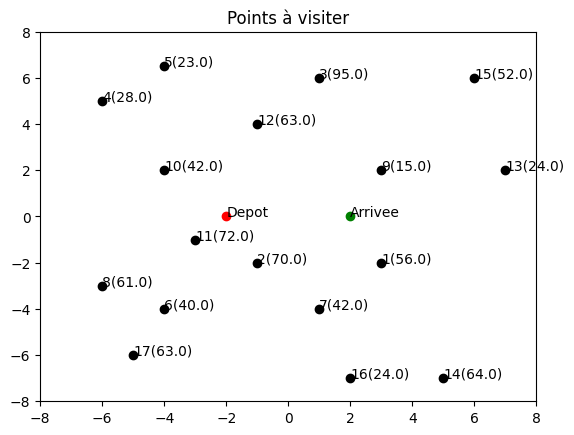

In [7]:
# Affichage des points
cmap = matplotlib.cm.get_cmap('Dark2')
for i, row in data.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'], row['y'], 'Depot')
    elif i == len(data)-1:
        plt.scatter(row['x'], row['y'], c='g')
        plt.text(row['x'], row['y'], 'Arrivee')
    elif i < len(data):
        plt.scatter(row['x'], row['y'], c='black')
        profit = row['profit']
        plt.text(row['x'], row['y'], f'{i}({profit})')

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.title('Points à visiter')
plt.show()

Afin de pouvoir résoudre le problème, il faut que l'on définisse des paramètres supplémentaires tel que le calcul des distances de chaque point avec les autres. Ci-dessous une matrice des distances.

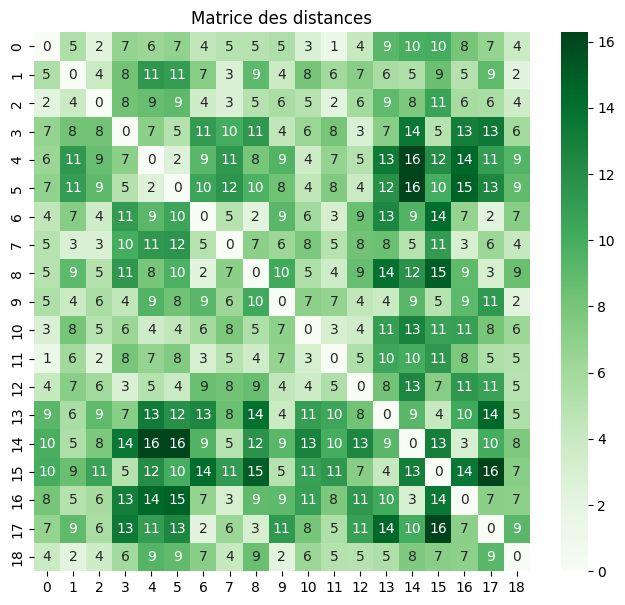

In [8]:
# Calcul des distances
distances = pd.DataFrame(distance_matrix(data[['x', 'y']].values, data[[
                         'x', 'y']].values), index=data.index, columns=data.index).values
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Greens', annot=True, fmt='.0f')
plt.title('Matrice des distances')
plt.show()


### Programmation linéaire

Avant toute chose, il est nécessaire de définir les variables python avec lesquels nous devons traiter pour définir la fonction objectif et les contraintes.

In [9]:
# Creation du probleme
problem = pulp.LpProblem('cvrp_mip', pulp.LpMaximize)

# Liaison des variables x et y defini plus haut
x = pulp.LpVariable.dicts('x', ((i, j, k) for i in range(0, n_point) for j in range(i+1, n_point)
                                for k in range(0, m_vehicle)), lowBound=0, upBound=1, cat='Binary')
y = pulp.LpVariable.dicts('y', ((i, k) for i in range(0, n_point)
                          for k in range(0, m_vehicle)), lowBound=0, upBound=1, cat='Binary')


#### Modélisation

Pour modéliser le problème en PL, nous avons tout d’abord défini deux ensembles:
- $V$ comme étant l’ensemble des sommets $i$ visité par un véhicule $k$
- $U$ l’ensemble des sommets (visités et non visités).

Nous avons les paramètres suivants : 
- $n$ est le nombre de points/sommets (dépôt et arrivée compris).
- $m$ est le nombre de véhicules maximum.
- $p_i$ correspond au profit du sommet $i$.
- $c_{ij}$ correspond au cout du sommet $i$ à $j$ (distance).
- $Lmax$ est le paramètre de distance maximum défini.

Nous avons défini les variables suivantes : 
- $x_{ijk}=1$ si l'arête {$v_i$, $v_j$} ϵ A$ est utilisé par la tournée $k$, 0 sinon
- $y_{ik}=1$ si le sommet $v_i$ ϵ $V$\{$v_1$, $v_n$} est visité par la tournée $k$, 0 sinon

Nous avons décidé de définir les arcs de façon non orientée, un sens sera imposé implicitement étant donné qu’il faut commencer depuis le point de dépôt. Mais un arc sera représenté de manière unique, en respectant la contrainte de j>i.

La fonction objectif se modélise comme tel :

$Max\sum_{i=2}^{n-1} \sum_{k=1}^{m} (p_i y_{ik})$

sous les contraintes

- $\forall i \quad \sum_{j=2}^{n} (x_{1jk}) = 1$
- $\forall i \quad \sum_{j=2}^{n} (x_{jnk}) = 1$
- $ \forall k, \quad   j= ${$ 2,...,n-1 $}$,  \quad \sum_{i<j} (x_{ijk})  + \sum_{i>j} (x_{jik}) = 2 y_{ik}$
- $\forall k \quad \sum_{i=1}^{n} \sum_{i<j} (c_{ij} x_{ijk}) \leq Lmax$
- $ i = ${$ 2,...,n-1 $}$ , \quad \sum_{k=1}^{m} (y_{ik}) \leq 1$
- $\forall k, |U|  \geq 3 , \quad \sum_{i,jϵU, i<j} (x_{ijk} ) \leq |U|-1$
- $x_{ijk}ϵ${$0,1$}$  \quad (1 \leq i < j \leq n) , \quad \forall k$
- $y_{ik}ϵ${$0,1$}$ \quad  i = ${$ 2,...,n-1 $}$ \quad, \forall k  $

In [10]:
# Definition de la fonction objectif
problem.setObjective(pulp.lpSum(
    [p[i] * y[i, k] for i in range(1, n_point-1) for k in range(0, m_vehicle)]))


In [11]:
# Definition des contraintes
# Un point est parcouru au plus une fois
for i in range(1, n_point-1):
    problem += pulp.lpSum([y[i, k] for k in range(0, m_vehicle)]) <= 1

# Le point de depot est parcouru par tous les vehicules
for k in range(0, m_vehicle):
    problem += pulp.lpSum(x[0, j, k] for j in range(1, n_point)) == 1

# Le point d'arrivé est parcouru par tous les vehicules
for k in range(0, m_vehicle):
    problem += pulp.lpSum(x[j, n_point-1, k] for j in range(0, n_point-1)) == 1

# Le degré de chaque sommet est égal à 2 s'il est parcouru
for k in range(0, m_vehicle):
    for i in range(1, n_point-1):
        problem += pulp.lpSum(x[i, j, k] for j in range(i+1, n_point)) + \
            pulp.lpSum(x[j, i, k] for j in range(0, n_point-1)
                       if i > j) == 2*y[i, k]

# Limite de la longueur du trajet
for k in range(0, m_vehicle):
    problem += pulp.lpSum([x[i, j, k]*distances[i, j]
                          for i in range(0, n_point) for j in range(i+1, n_point)]) <= l_max

# Sous-tours interdits
subtours = []
for i in range(2, n_point-2):
    subtours += itertools.combinations(range(1, n_point-1), i)

for s in subtours:
    problem += pulp.lpSum(x[i, j, k] for i, j in itertools.permutations(s, 2)
                          if i < j for k in range(m_vehicle)) <= len(s) - 1


## Résolution

Désormais, le problème étant modélisé, il ne nous reste plus qu'à exécuter la ``résolution`` du problème. Nous nous attendons à une exécution durant plusieurs heures avant de nous retourner une ``solution optimale``. 

Et c'est effectivement le cas. La ``résolution`` a été effectuée en ``174 minutes`` soit un peu moins de 3h. Il nous a été retourné une ``solution optimale unique`` avec un profit de ``683``. Ci-dessous un graphe modélisant les points et les routes des véhicules associés ainsi que

In [12]:
# Resolution du probleme
status = problem.solve()

# Affichage du resultat
status, pulp.LpStatus[status], pulp.value(problem.objective)

(1, 'Optimal', 683.0)

Routes (P1, P2, V):  [(0, 11, 0), (3, 9, 0), (3, 12, 0), (9, 18, 0), (10, 11, 0), (10, 12, 0), (0, 7, 1), (1, 14, 1), (1, 18, 1), (7, 14, 1), (0, 8, 2), (2, 6, 2), (2, 18, 2), (6, 17, 2), (8, 17, 2)]
Vehicule 0 : 287.0
Vehicule 1 : 162.0
Vehicule 2 : 234.0
Total : 683.0


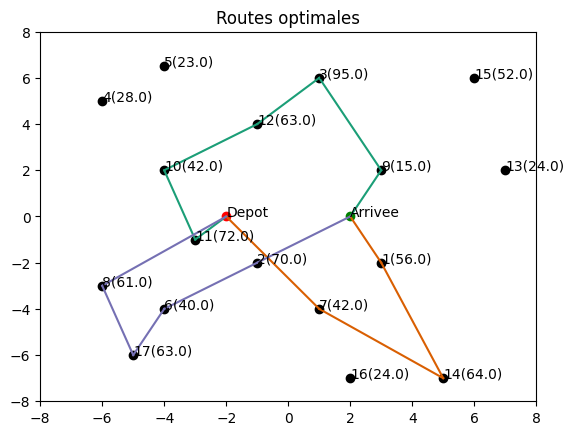

In [18]:
# Affichage de la route optimale
cmap = matplotlib.cm.get_cmap('Dark2')
for i, row in data.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'], row['y'], 'Depot')
    elif i == len(data)-1:
        plt.scatter(row['x'], row['y'], c='g')
        plt.text(row['x'], row['y'], 'Arrivee')
    elif i < len(data):
        plt.scatter(row['x'], row['y'], c='black')
        profit = row['profit']
        plt.text(row['x'], row['y'], f'{i}({profit})')

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.title('Routes optimales')

routes = [(i, j, k) for k in range(0, m_vehicle) for i in range(0, n_point)
          for j in range(i+1, n_point) if pulp.value(x[i, j, k]) == 1]

print("Routes (P1, P2, V): ", routes)

# Profit par vehicule
for k in range(0, m_vehicle):
    print(
        f'Vehicule {k} : {pulp.value(pulp.lpSum([p[i] * y[i, k] for i in range(1, n_point-1)]))}')
# Total du profit
print(
    f'Total : {pulp.value(pulp.lpSum([p[i] * y[i, k] for i in range(1, n_point-1) for k in range(0, m_vehicle)]))}')
# Tracage des routes
for v in range(m_vehicle):
    for r in routes:
        i, j, k = r
        if k == v:
            plt.plot([data['x'][i], data['x'][j]], [
                     data['y'][i], data['y'][j]], c=cmap(v))
plt.show()


## Bonus - Heuristique Kmeans

Ayant terminé la résolution du problème en méthode solveur, et ayant ciblé que les solutions utilisant un solveur revenaient à le modéliser en programmation linéaire, et la complexité temporelle est exponentielle. Il est donc inconcevable d'obtenir des résultats de cette manière pour de grandes instances. 

Nous avons pris l'initiative de travailler sur une ``méthode heuristique`` qui serait avantageuse sur le plan temporel et qui proposerait un résultat ayant un pourcentage d'approcher la méthode optimale élevée.
<br>

À notre connaissance, et d'après la revue de la littérature, aucun algorithme ``métaheuristique`` efficace n'existe pour la résolution des mVRP à grande échelle. Nous avons traiter le problème de routage de véhicules multiples moins fréquemment abordé et plus réaliste avec une heuristique de clustering spécialisée, à savoir l'algorithme de ``clustering k-means``.<br>

Basiquement, cette méthode qui consiste en un partitionnement en ``k-means`` est une méthode de partitionnement de données et un problème d'``optimisation combinatoire``. Étant donné des points et un entier $k$, le problème est de diviser les points en k groupes, souvent appelés clusters, de façon à minimiser une certaine fonction. On considère la distance d'un point à la moyenne des points de son cluster : la fonction à minimiser est la somme des carrés de ces distances. <br>

Nous nous sommes basés sur un code récupéré sur ``github`` pour implémenter cette heuristique. 
Nous avons effectué plusieurs modifications sur le code afin de l’adapter à notre problématique, notamment car il utilisait des contraintes non compatibles avec notre modèle. Exemple : l’algorithme prenait en compte une durée de ``déchargement/livraison`` à chaque point de dépôt, ou encore la minimisation du nombre de véhicules utilisés tout en maximisant le ``profit``. Ce code est vraiment adapté au problème logistique de tous les jours que peuvent rencontrer les grandes entreprises telles que la poste ou Amazon.<br>

Concernant les ajouts que nous avons effectués :
On a fait en sorte que le point de ``dépôt`` soit le départ et défini un point d'``arrivée``. Nous avons fait en sorte d'effectuer un ``calcul de distances euclidiennes`` maximiser le profit en utilisant autant de véhicules qu'on est limité. Concernant la définition de la fonction objectif et des contraintes, ce sont les mêmes que présenté plus tôt. Évidemment, l'instance est la même dans le but de comparer les résultats.

Le code est joint au dossier, et voici une image du graphe solution qu'on extrait.

Le résultat obtenu par cette heuristique est tout à fait ``remarquable``. Surtout que le ``temps d'exécution`` est beaucoup ``plus faible`` que celui du solveur. Nous avons ici un temps d'exécution inférieur à ``0.1 seconde``. Certes le résultat n'est pas exactement le même et nécessite quelques ajustements d'optimisation, mais dans la globalité, nous obtenons un résultat très similaire et pourrait être ``avantageux`` du fait qu'on utilise moins de temps. Cependant, le ``profit`` total est de ``619`` comparé à 681 pour la solution solveur.

0 11 10 12 3 0 Cost: 17.72 Profit: 272
0 6 8 17 2 0 Cost: 17.76 Profit: 234
0 7 1 9 0 Cost: 17.21 Profit: 113
Total Cost: 52.69566930679163 Total Profit: 619.0


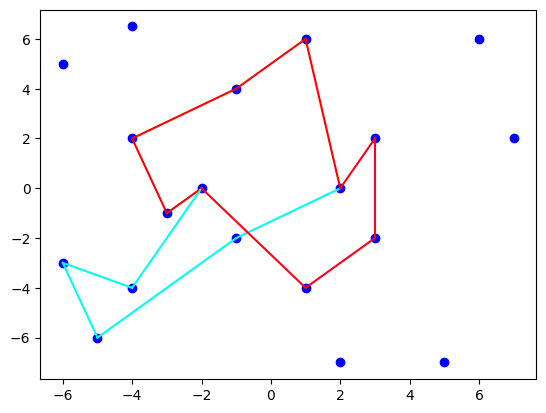

In [31]:
import sys
sys.path.insert(0, '../kMeans')
from Solver import *

m = Model()
m.BuildModel()
s = Solver(m)
sol = s.solve()

## Analyse
Nous remarquons donc un ``bon fonctionnement`` du solveur ne prenant pas en compte le temps d'exécution, et un excellent rapport solution/temps de l'heuristique.

1. Solveur PuLP
   
Le résultat proposé est ``optimal`` selon le solveur, il est très intéressant, car nous pouvons remarquer les choix effectués vis-à-vis des points dans le but de ``maximiser le profit``. Notamment la route orange qui correspond au véhicule 1 qui a fait le choix de partir vers ``le point 14`` au lieu du ``point 16`` en ayant la contrainte de choisir l'un des deux pour respecter la distance maximum. On a donc un profit total de ``683``.

Concernant le temps d'exécution, la solveur a été lancée et a recherché une solution pendant un peu moins de ``3h pour 19 points``. Ce temps est beaucoup trop important pour une résolution liée ``VRP`` à 19 points. Mais ceci est un problème général lié au ``VRP`` comme celui du TSP. La complexité temporelle est exponentielle vis-à-vis du nombre de destinations à avoir.

2. Heuristique KMeans

Le résultat obtenu n'est ``pas optimal``, mais le rapport ``solution/temps`` est ``très avantageux``. Ici le ``profit total est de 619``, et qui est déjà un très bon score pour ce le temps d'exécution. Nous sommes ``persuadés`` qu'avec plus de temps sur ce problème nous pouvons ``améliorer l'algorithme ``afin d'obtenir un résultat équivalent à celui du solveur. Également, certaines optimisations sont nécessaires comme la minimisation de la distance malgré qu'on ne puisse pas atteindre de nouveaux points.

## Conclusion 

Dans ce mémoire, nous avons présenté le Problème de m-Tournées Sélectives (``TOP``) dérivé du VRP, ainsi que ses propriétés et caractéristiques. Ensuite, nous avons modélisé le ``TOP`` sous forme d’un graphe et sous forme d’un ``programme linéaire`` en entier numérique. Enfin, nous avons effectué une revue de la littérature du ``TOP`` et celle des problèmes voisins. Nous avons présenté, dans cette partie, un aperçu rapide des techniques et une méthode déjà utilisées pour résoudre le ``TOP``.<br>
Nous avons constaté que le ``TOP`` est un problème NP-difficile. Sa résolution de façon exacte n’est pas actuellement possible pour des instances de grande taille au vu de sa ``complexité temporelle exponentielle``.<br>
La majorité des travaux, existants dans la littérature, sont basées sur des méthodes approchées.<br>

Finalement, l'étude de ce sujet est très intéressante et instructive. Nous trouvons qu'il est davantage motivant de travailler sur des méthodes/problèmes de l'actualité et pensons sincèrement suivre personnellement de près ces problèmes et peut être même travailler dessus en entreprise.


### Sources et Aides

- Solving VRP by MIP using PuLP (https://www.kaggle.com/code/itoeiji/solving-tsp-and-vrp-by-mip-using-pulp/notebook)
- Github : https://github.com/Ioannis-Triantafyllakis/Vehicle-Routing-Problem-with-Knapsack
- These : Heuristiques pour un Problème de m-Tournées Sélectives (https://tel.archives-ouvertes.fr/tel-00440494)
- Reseach gate : https://www.researchgate.net/publication/267334865
- These UTC : Problèmes de tournées de véhicules et application industrielle pour la réduction de l’empreinte écologique (https://theses.hal.science/tel-00966428)
- Wikipedia
- Youtube videos
